In [1]:
# Import our relevant libraries:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import fisher_exact
from scipy.stats import zscore
from scipy.stats import ranksums
from sklearn.linear_model import LogisticRegression
import scanpy as sc
import anndata
import matplotlib
from matplotlib.pyplot import rc_context
import numba
import os
import scrublet as scr
from scipy.stats import ttest_ind
from sklearn import metrics

In [2]:
# Adjust font and visual modifications of the plots for the journal:
plt.rcParams['font.sans-serif']=['Arial']
plt.rcParams['axes.axisbelow'] = True

In [3]:
# set directory for saving the plots:
sc.settings.figdir = r'C:\Users\KerenYlab\OneDrive - Technion\Documents\lab_notebooks_ofir\cd38_project'

# Conduct QC on the NSCLC dataset of Caushi et al.:

In [4]:
# Load the data:
adata_Caushi = sc.read(r"C:\Users\KerenYlab\OneDrive - Technion\Documents\lab_notebooks_ofir\tcr_seq_analysis_files\counts_adata_files\adata_counts_Caushi.h5ad")
adata_Caushi

AnnData object with n_obs × n_vars = 599813 × 33538
    obs: 'patient', 'sample', 'response', 'tissue_type', 'treatment', 'study', 'cluster_name', 'cancer_type'

In [5]:
# Calculate mitochondrial gene-count per cell:
adata_Caushi.var['mt'] = adata_Caushi.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_Caushi, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\plotting\_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


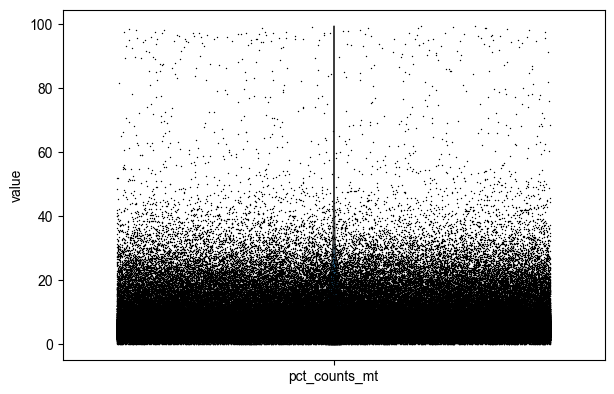

In [9]:
# visualize the mitochondrial gene-count per cell:
sc.pl.violin(
    adata_Caushi,
    "pct_counts_mt",
    jitter=0.4
)

In [10]:
# retain cells with less than 10% of mitochondrial gene-count:
adata_Caushi = adata_Caushi[adata_Caushi.obs.pct_counts_mt < 10, :]

In [11]:
# remove cells with less than 200 genes and gene expressed in less than 3 cells:
sc.pp.filter_cells(adata_Caushi, min_genes=200)
sc.pp.filter_genes(adata_Caushi, min_cells=3)

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\preprocessing\_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [13]:
# apply scrublet:
scrub = scr.Scrublet(adata_Caushi.X, expected_doublet_rate=0.05)

In [11]:
adata_Caushi.obs['doublet_scores'], adata_Caushi.obs['predicted_doublets'] = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 11.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.3%
Elapsed time: 6319.6 seconds


(<Figure size 800x300 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

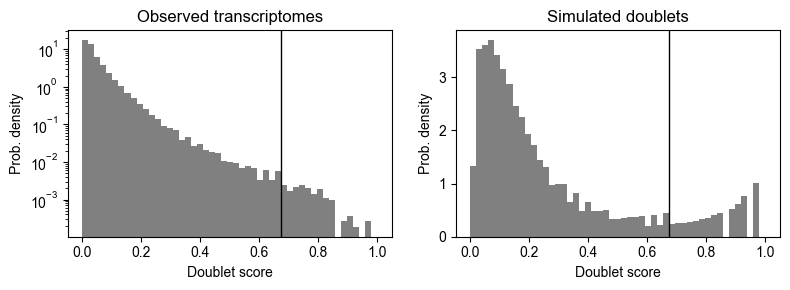

In [12]:
# visualize scrublet:
scrub.plot_histogram()

In [15]:
# remove cells having doublet_score higher than 0.3:
adata_Caushi = adata_Caushi[adata_Caushi.obs['doublet_scores'] < 0.3]
adata_Caushi

View of AnnData object with n_obs × n_vars = 534439 × 24625
    obs: 'patient', 'sample', 'response', 'tissue_type', 'treatment', 'study', 'cluster_name', 'cancer_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [ ]:
# adata_Caushi.write(r"C:\Users\KerenYlab\OneDrive - Technion\Documents\lab_notebooks_ofir\tcr_seq_analysis_files\counts_adata_files\adata_counts_Caushi_following_QC.h5ad")

# Main Figure 1 - panels M-N:

In [15]:
# load the data following QC:
adata_caushi = sc.read(r"C:\Users\KerenYlab\OneDrive - Technion\Documents\lab_notebooks_ofir\tcr_seq_analysis_files\counts_adata_files\adata_counts_Caushi_following_QC.h5ad")
adata_caushi

AnnData object with n_obs × n_vars = 534439 × 24625
    obs: 'patient', 'sample', 'response', 'tissue_type', 'treatment', 'study', 'cluster_name', 'cancer_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [16]:
# focus solely on tumor samples:
adata_caushi = adata_caushi[adata_caushi.obs['tissue_type'] == 'Tumor']
adata_caushi

View of AnnData object with n_obs × n_vars = 400532 × 24625
    obs: 'patient', 'sample', 'response', 'tissue_type', 'treatment', 'study', 'cluster_name', 'cancer_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [17]:
# Normalization and log-transformation:
sc.pp.normalize_total(adata_caushi, target_sum=1e4)
sc.pp.log1p(adata_caushi, base = 2)

C:\Users\KerenYlab\Anaconda3\envs\TCR_seq_env\lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
# Filter dataset to include only CD8 T cells - done similarly be Sade-Feldman et al., Cell 2018:
# This will result with a pandas dataframe of the cells for generating the figure:
log2_normalized_df = sc.get.obs_df(adata_caushi, ['PTPRC', 'CD3E', 'CD8A', 'CD8B', 'NCR1', 'NCAM1', 'FOXP3', 'CD38', 'sample', 'response', 'treatment'])
cd8_df_NSCLC = log2_normalized_df[(log2_normalized_df['PTPRC'] > 1) & (log2_normalized_df['CD3E'] > 1) & ((log2_normalized_df['CD8A'] > 1) | (log2_normalized_df['CD8B'] > 1)) & (log2_normalized_df['NCR1'] < 1) & (log2_normalized_df['NCAM1'] < 1) & (log2_normalized_df['FOXP3'] < 1)]
cd8_df_NSCLC

,PTPRC,CD3E,CD8A,CD8B,NCR1,NCAM1,FOXP3,CD38,sample,response,treatment
MD01-024_tumor_1_AAACGGGTCCGCATCT-1,4.317550,2.055392,2.055392,0.000000,0.0,0.0,0.0,0.0,MD01-024_tumor_1,NR,Post
MD01-024_tumor_1_AAAGATGGTCCGAATT-1,2.570339,3.983539,3.071975,0.000000,0.0,0.0,0.0,0.0,MD01-024_tumor_1,NR,Post
MD01-024_tumor_1_AAAGCAATCTGTCCGT-1,3.071661,3.443148,1.794576,0.000000,0.0,0.0,0.0,0.0,MD01-024_tumor_1,NR,Post
MD01-024_tumor_1_AAAGTAGCAGCTGTGC-1,3.717064,2.822798,1.596988,0.000000,0.0,0.0,0.0,0.0,MD01-024_tumor_1,NR,Post
MD01-024_tumor_1_AACACGTTCAAACGGG-1,3.773816,4.074493,2.524655,1.370045,0.0,0.0,0.0,0.0,MD01-024_tumor_1,NR,Post
...,...,...,...,...,...,...,...,...,...,...,...
MD043-006_tumor_1_TTTGTCAAGTGGTCCC-1,3.210113,4.435334,3.210113,2.358147,0.0,0.0,0.0,0.0,MD043-006_tumor_1,NR,Post
MD043-006_tumor_1_TTTGTCACAAAGCAAT-1,4.110259,3.427934,3.809064,3.427934,0.0,0.0,0.0,0.0,MD043-006_tumor_1,NR,Post
MD043-006_tumor_1_TTTGTCACAAGCCGCT-1,4.844564,2.710682,3.220248,3.220248,0.0,0.0,0.0,0.0,MD043-006_tumor_1,NR,Post
MD043-006_tumor_1_TTTGTCACAGATCTGT-1,3.340116,4.018940,4.478714,4.267066,0.0,0.0,0.0,0.0,MD043-006_tumor_1,NR,Post


C:\Users\KerenYlab\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0, '0.0'),
  Text(0, 0, '0.2'),
  Text(0, 0, '0.4'),
  Text(0, 0, '0.6'),
  Text(0, 0, '0.8'),
  Text(0, 0, '1.0')])

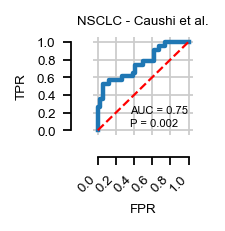

In [29]:
samples = list(cd8_df_NSCLC['sample'].unique())

# create the ROC curve and calculate AUC score:
fraction = []
goods = []
bads = []
for sample in samples:
    good = cd8_df_NSCLC[['sample', 'CD38']][(cd8_df_NSCLC['sample'] == sample) & (cd8_df_NSCLC['CD38'] <= 1)].shape[0]
    bad = cd8_df_NSCLC[['sample', 'CD38']][(cd8_df_NSCLC['sample'] == sample) & (cd8_df_NSCLC['CD38'] > 1)].shape[0]
    ratio = bad / (bad + good)
    fraction.append(ratio)
    goods.append(good)
    bads.append(bad)
    
ratios_df = pd.DataFrame({'sample' : samples, 'CD38-' : goods, 'CD38+' : bads, 'fraction' : fraction})
ratios_df = ratios_df.set_index('sample')
ratios_df['Binary Response'] = list(cd8_df_NSCLC[['sample', 'response']].drop_duplicates().reset_index(drop = True)['response'].apply(lambda x: 1 if x == 'R' else 0))

sc.settings.set_figure_params(dpi=80, dpi_save=600, frameon=True, figsize=(12, 12), fontsize = 6, facecolor='white', format = 'tiff')
X = ratios_df[['fraction']]
y = ratios_df[['Binary Response']]
log_regression = LogisticRegression()
log_regression.fit(X,y)
y_pred_proba = log_regression.predict_proba(X)[::,1]
auc = metrics.roc_auc_score(y, y_pred_proba)
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_proba)

# calculate p-value using two-sided t-test:
pvalue = ttest_ind(ratios_df['fraction'][ratios_df['Binary Response'] == 1], ratios_df['fraction'][ratios_df['Binary Response'] == 0])[1]

pvalue = f'{pvalue:.3f}' if pvalue * 10**3 > 1 else f'{pvalue:.2e}'
if 'e' in pvalue:
    pvalue = pvalue.split('e')
    pvalue[1] = '-' + pvalue[1][1:]
    pvalue[1] = str(int(pvalue[1]))
    pvalue = f'{pvalue[0]}*' + fr'$10^{{{pvalue[1]}}}$'
    

plt.figure(figsize = (0.8,0.8))
lw = 2
plt.plot(fpr, tpr, lw=lw)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'NSCLC - Caushi et al.', size = 6)
#plt.grid()
plt.ylim(-0.05,1.05)
plt.xlim(-0.05,1.05)
yticks_loc = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.yticks(yticks_loc)
xticks_loc = [0, 0.2, 0.4, 0.6, 0.8, 1]
plt.xticks(yticks_loc)
#plot a diagonal line
plt.plot([0,1],[0,1], color = 'red', ls="--", lw = 1)
plt.annotate(f'AUC = {auc:.2f}', [0.35, 0.2], size = 5)
plt.annotate(f'P = {pvalue}', [0.35, 0.05], size = 5)
sns.despine(offset = 10, trim = True)
plt.xticks(rotation=45, ha = 'right',  position=(0,0))
# plt.savefig(r'%s' % os.path.join(r'cd38_project\auc_NSCLC_for_or_yam_corrected.jpeg'), bbox_inches='tight', dpi=600)

In [30]:
ratios_df['Binary Treatment'] = cd8_df_NSCLC[['sample', 'treatment']].drop_duplicates().set_index('sample')['treatment']

In [45]:
# save the raw data for Or-yam - this was used for Main Figure 1 - panels M-N,
# in a separate code by Or-yam:
# ratios_df.to_csv(r"cd38_project\NSCLC_data.csv")